# Dual perturbation

In [1]:
import scanpy as sc
import pyturbseq as prtb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})

In [2]:
test_data_path = "../tests/data/norman2019_subset_doubles.h5ad.gz"
adata = sc.read_h5ad(test_data_path)
print(f"Loaded {adata.n_obs} cells and {adata.n_vars} genes")
adata.obs['perturbation'].value_counts()

Loaded 1984 cells and 500 genes


perturbation
KLF1            519
control         500
SET             268
SET_KLF1        167
COL2A1          147
SAMD1           120
PTPN12          113
SAMD1_PTPN12     77
KLF1_COL2A1      73
Name: count, dtype: int64

In [3]:
# Calculate target gene changes
prtb.utils.calculate_target_change(adata, perturbation_column='perturbation', control_value='control', delim='_')

Computing target change for 'perturbation' across 1984 cells...
	Checking if data is normalized to counts per cell...
		Data is not normalized to counts per cell. Normalizing...
	Generating perturbation matrix from 'perturbation' column...
Found 6 unique features.
	Found 5 unique perturbations in perturbation column.
	Computing target change for each cell...


Groups: 100%|██████████| 1/1 [00:00<00:00, 34.14it/s]

Target change calculation done. Storing in AnnData...
	Multiple perturbations found. Keeping metrics in .obsm...


Calculating target gene heatmap for perturbation column...


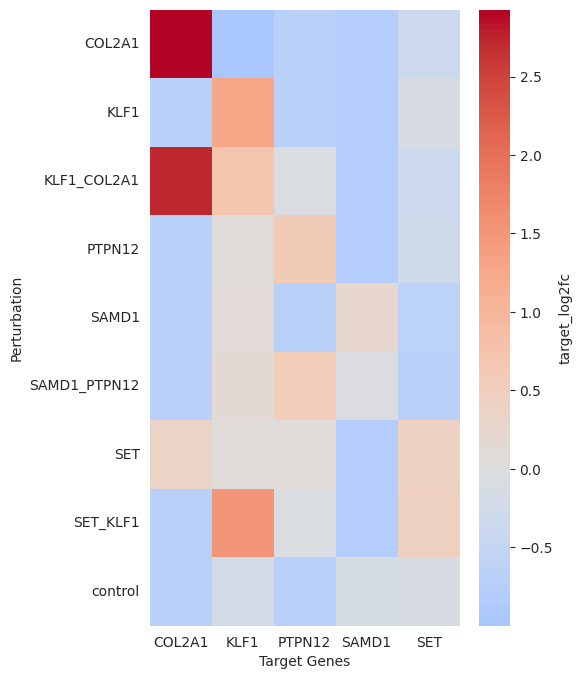

In [4]:
prtb.plot.target_change_heatmap(adata, perturbation_column='perturbation', metric='log2fc', figsize=(5, 8))

# Interaction Modeling

### Normal 2019

For Tom Norman's modeling approach, we model the dual perturbation as a linear combination of each perturbation individually. The original implementation used z-score gene-expression values as input. Note: the z-score approach requires meangingful variability (ie non-zero stdev) in the reference population and so is only suitable for well-expressed genes. The `pyturbseq` method below can use any transformed values as input but here we show with the original z-score approach

In [5]:
sc.pp.normalize_total(adata)

In [6]:
zdata = adata.copy()
zdata.X = prtb.utils.zscore(zdata, covariates=['gemgroup'], ref_col='perturbation', ref_val='control')

Splitting into 2 groups based on covariates: ['gemgroup']


In [7]:
#now pseudobulk but instead of default sum aggregation, we use the mean
zdata = prtb.utils.pseudobulk(zdata, 'perturbation', method='mean')
zdata.obs.set_index('perturbation', inplace=True)
zdata.obs.head()

Aggregating Samples: 100%|██████████| 9/9 [00:00<00:00, 11070.01it/s]


""
perturbation
COL2A1
KLF1
KLF1_COL2A1
PTPN12
SAMD1


In [8]:
#drop any genes that contain NaNs
print(f"Prior to dropping NaNs: {zdata.shape}")
zdata = zdata[:, np.isnan(zdata.X).sum(axis=0) == 0]
print(f"After dropping NaNs: {zdata.shape}")

Prior to dropping NaNs: (9, 500)
After dropping NaNs: (9, 500)


### Run Norman model on z-scored data

In [9]:
metric2term = {
    "coef_norm2": "Magnitude",
    "abs_log10_ratio_coefs": "Dominance",
    "dcor_AB_fit": "Model fit",
    "dcor_AnB_AB": "Similarity of singles to double",
    "dcor_A_B": "Similarity between singles",
    "dcor_ratio": "Equality of contribution",
}

In [10]:
# norman model expects a dataframe indexed by perturbation
zdf = zdata.to_df()
zdf.head(2)

,AAK1,ABI2,AC006262.5,AC079466.1,ACP5,ACSM3,ACTG1,ACYP2,ADAMTSL4,AIF1,...,YBX1,ZC3HAV1,ZCCHC11,ZFP36L1,ZFP36L2,ZMYND8,ZNF280B,ZNF431,ZNHIT1,ZSCAN16-AS1
perturbation,,,,,,,,,,,,,,,,,,,,,
COL2A1,0.046356,0.086573,-0.106690,-0.502617,-0.246890,0.432707,-0.122866,-0.031518,-0.141001,1.196417,...,-0.805997,-0.355207,-0.163847,0.209580,-0.230948,-0.058747,-0.171404,-0.226362,-0.263784,-0.139944
KLF1,0.006536,-0.111741,-0.198255,-0.329789,0.726224,-0.136443,0.066989,-0.030183,0.067323,-0.436524,...,0.504252,-0.099285,-0.172542,0.081293,-0.083037,-0.220093,-0.003538,-0.108309,0.098054,-0.088667


In [11]:
#all dual perturbation
metrics, predicted = prtb.interaction.norman_model(
	zdf, control_value='control',
	perturbations='KLF1_COL2A1',
	delim='_', 
	)

print(f"KLF1_COL2A1:")
for m, t in metric2term.items():
    print(f"\t{t}: {metrics[m]:.2f}")

Fitting model for KLF1_COL2A1
	A: KLF1 B: COL2A1
KLF1_COL2A1:
	Magnitude: 1.04
	Dominance: 0.11
	Model fit: 0.80
	Similarity of singles to double: 0.74
	Similarity between singles: 0.18
	Equality of contribution: 0.74


In [12]:
#all dual perturbation
metrics, predicted = prtb.interaction.norman_model(
	zdf, control_value='control',
	delim='_',  # make sure that 'delim' uniquely identifies the dual perturbations. In this case, norman model can simply auto-detect the dual perturbations
	)
metrics.head(2)

Auto-detected 3 dual perturbations to analyze
Analyzing 3 perturbations...


Fitting models: 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


,a,b,corr_a,corr_b,corr_sum,corr_a_b,fit_spearmanr,fit_pearsonr,fit_cosine_dist,coef_a,...,dcor_A_B,dcor_AnB_fit,dcor_AB_fit,dcor_A,dcor_B,dcor_A_fit,dcor_B_fit,min_dcor,max_dcor,dcor_ratio
perturbation,,,,,,,,,,,,,,,,,,,,,
KLF1_COL2A1,KLF1,COL2A1,0.449503,0.692096,0.802264,0.144517,0.810628,0.905204,0.097013,0.641416,...,0.177095,0.907479,0.799020,0.489685,0.665869,0.555287,0.830333,0.489685,0.665869,0.735407
SAMD1_PTPN12,SAMD1,PTPN12,0.780609,0.579722,0.805799,0.456056,0.818267,0.831452,0.167923,1.002126,...,0.445556,0.952021,0.802799,0.758460,0.572967,0.941780,0.663169,0.572967,0.758460,0.755434
